# Hazelnut Defect Dataset EDA (hazelnut_2)

This notebook explores the second hazelnut dataset located at `data/hazelnut_2`.

## TLDR

Probably not useful, the hazelnuts are nut itself, not the shells.

**Dataset overview:**
- Total images: 78 (much smaller than MVTec's ~500)
- Good images: 34
- Defect images: 22 (17 colour, 5 crack)
- Defect ratio: ~39% (vs ~20% in MVTec) - more balanced

**Key differences from MVTec:**
- No train/test split provided
- Different defect types: `colour` and `crack` only
- Likely different image characteristics (backgrounds, lighting, resolution)

**Recommendations for robust data:**
- See analysis below for specific recommendations

In [1]:
from pathlib import Path
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

SEED: int = int(os.getenv("SEED", "42"))
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path("data/hazelnut_2")
assert DATA_DIR.exists(), f"Dataset not found at {DATA_DIR}"

pd.set_option("display.max_rows", 200)
plt.rcParams["figure.figsize"] = (12, 6)

print(f"Using dataset: {DATA_DIR}")

Using dataset: data/hazelnut_2


## 1. Dataset Structure & Class Distribution

In [2]:
# Define paths
good_dir = DATA_DIR / "good"
colour_dir = DATA_DIR / "colour"
crack_dir = DATA_DIR / "crack"
mask_dir = DATA_DIR / "mask"

exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def list_images(d: Path):
    if not d.exists():
        return []
    return sorted([p for p in d.iterdir() if p.is_file() and p.suffix.lower() in exts])

good_images = list_images(good_dir)
colour_images = list_images(colour_dir)
crack_images = list_images(crack_dir)

print(f"Good images: {len(good_images)}")
print(f"Colour defect images: {len(colour_images)}")
print(f"Crack defect images: {len(crack_images)}")
print(f"Total images: {len(good_images) + len(colour_images) + len(crack_images)}")
print(f"\nDefect ratio: {(len(colour_images) + len(crack_images)) / (len(good_images) + len(colour_images) + len(crack_images)):.1%}")

Good images: 34
Colour defect images: 17
Crack defect images: 5
Total images: 56

Defect ratio: 39.3%


/tmp/ipykernel_10051/902101697.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_df, x="class", y="count", ax=axes[0], palette="Set2")


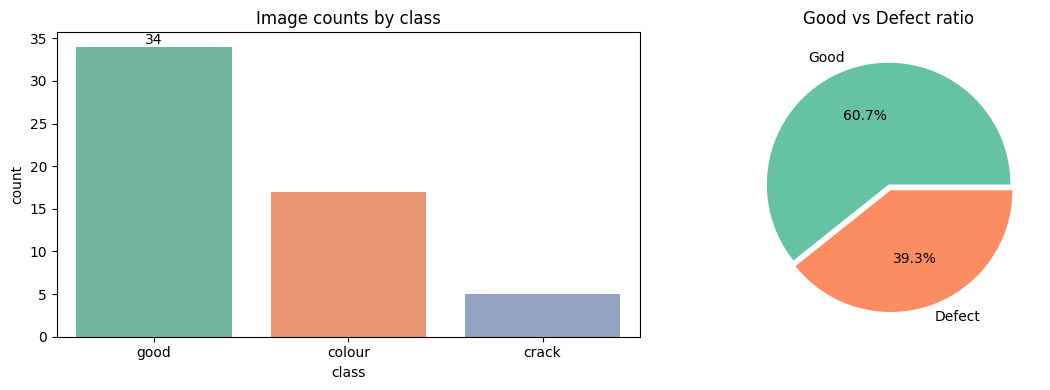

class  count
0    good     34
1  colour     17
2   crack      5

In [3]:
# Class distribution visualization
counts_df = pd.DataFrame([
    {"class": "good", "count": len(good_images)},
    {"class": "colour", "count": len(colour_images)},
    {"class": "crack", "count": len(crack_images)},
])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
sns.barplot(data=counts_df, x="class", y="count", ax=axes[0], palette="Set2")
axes[0].set_title("Image counts by class")
axes[0].bar_label(axes[0].containers[0])

# Pie chart for defect ratio
binary_counts = [len(good_images), len(colour_images) + len(crack_images)]
axes[1].pie(binary_counts, labels=["Good", "Defect"], autopct="%1.1f%%", 
            colors=["#66c2a5", "#fc8d62"], explode=[0, 0.05])
axes[1].set_title("Good vs Defect ratio")

plt.tight_layout()
plt.show()

counts_df

## 2. Image Properties Analysis

In [4]:
# Collect all images for analysis
all_images = []
for p in good_images:
    all_images.append(("good", p))
for p in colour_images:
    all_images.append(("colour", p))
for p in crack_images:
    all_images.append(("crack", p))

# Analyze image properties
records = []
errors = []

for cls, p in tqdm(all_images, desc="Analyzing images"):
    try:
        with Image.open(p) as img:
            w, h = img.size
            mode = img.mode
            file_size = p.stat().st_size / 1024  # KB
        records.append({
            "class": cls,
            "path": str(p),
            "filename": p.name,
            "width": w,
            "height": h,
            "aspect_ratio": w / h,
            "mode": mode,
            "file_size_kb": file_size,
        })
    except Exception as e:
        errors.append((str(p), repr(e)))

img_df = pd.DataFrame(records)

print(f"Readable images: {len(records)}")
print(f"Unreadable images: {len(errors)}")
if errors:
    print("Errors:", errors)

img_df.head(10)

Analyzing images: 100%|██████████| 56/56 [00:00<00:00, 11207.76it/s]

Readable images: 56
Unreadable images: 0


class                         path filename  width  height  aspect_ratio  \
0  good  data/hazelnut_2/good/00.jpg   00.jpg    512     512      1.000000   
1  good  data/hazelnut_2/good/01.jpg   01.jpg    512     522      0.980843   
2  good  data/hazelnut_2/good/02.jpg   02.jpg    512     512      1.000000   
3  good  data/hazelnut_2/good/03.jpg   03.jpg    512     512      1.000000   
4  good  data/hazelnut_2/good/04.jpg   04.jpg    512     512      1.000000   
5  good  data/hazelnut_2/good/05.jpg   05.jpg    512     512      1.000000   
6  good  data/hazelnut_2/good/06.jpg   06.jpg    512     512      1.000000   
7  good  data/hazelnut_2/good/07.jpg   07.jpg    512     512      1.000000   
8  good  data/hazelnut_2/good/08.jpg   08.jpg    512     512      1.000000   
9  good  data/hazelnut_2/good/09.jpg   09.jpg    512     512      1.000000   

  mode  file_size_kb  
0  RGB    108.643555  
1  RGB    112.179688  
2  RGB    107.166016  
3  RGB    110.194336  
4  RGB    109.701172  
5  RGB    110.387695  
6  RGB    110.043945  
7  RGB    114.049805  
8  RGB    112.122070  
9  RGB    113.948242

In [5]:
# Image size summary
print("=== Image Size Summary ===")
print(f"\nUnique dimensions: {img_df.groupby(['width', 'height']).size().reset_index(name='count')}")
print(f"\nWidth range: {img_df['width'].min()} - {img_df['width'].max()}")
print(f"Height range: {img_df['height'].min()} - {img_df['height'].max()}")
print(f"\nColor modes: {img_df['mode'].value_counts().to_dict()}")
print(f"\nFile size (KB): min={img_df['file_size_kb'].min():.1f}, max={img_df['file_size_kb'].max():.1f}, mean={img_df['file_size_kb'].mean():.1f}")

=== Image Size Summary ===

Unique dimensions:    width  height  count
0    512     512     55
1    512     522      1

Width range: 512 - 512
Height range: 512 - 522

Color modes: {'RGB': 56}

File size (KB): min=95.9, max=118.1, mean=112.6


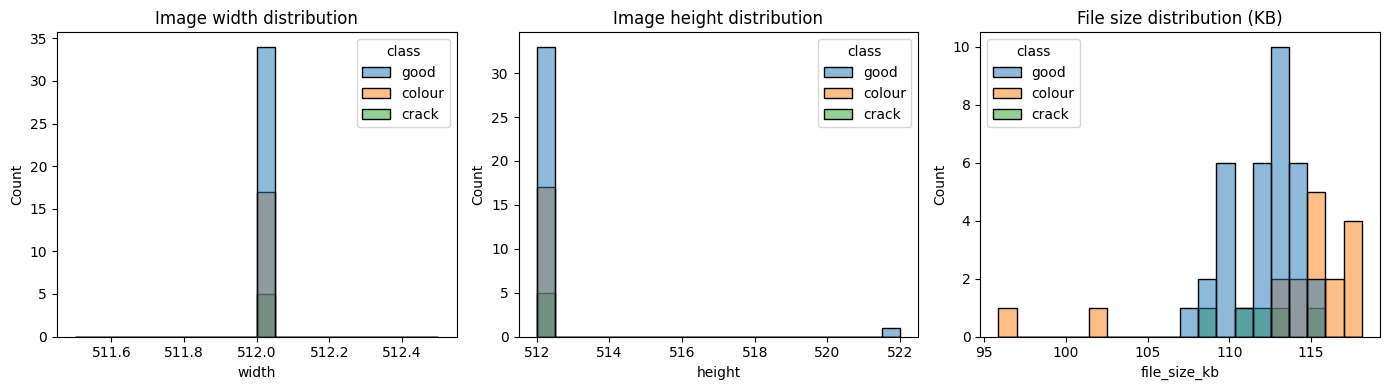

In [6]:
# Visualize size distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Width distribution
sns.histplot(data=img_df, x="width", hue="class", ax=axes[0], bins=20)
axes[0].set_title("Image width distribution")

# Height distribution
sns.histplot(data=img_df, x="height", hue="class", ax=axes[1], bins=20)
axes[1].set_title("Image height distribution")

# File size distribution
sns.histplot(data=img_df, x="file_size_kb", hue="class", ax=axes[2], bins=20)
axes[2].set_title("File size distribution (KB)")

plt.tight_layout()
plt.show()

## 3. Visual Samples

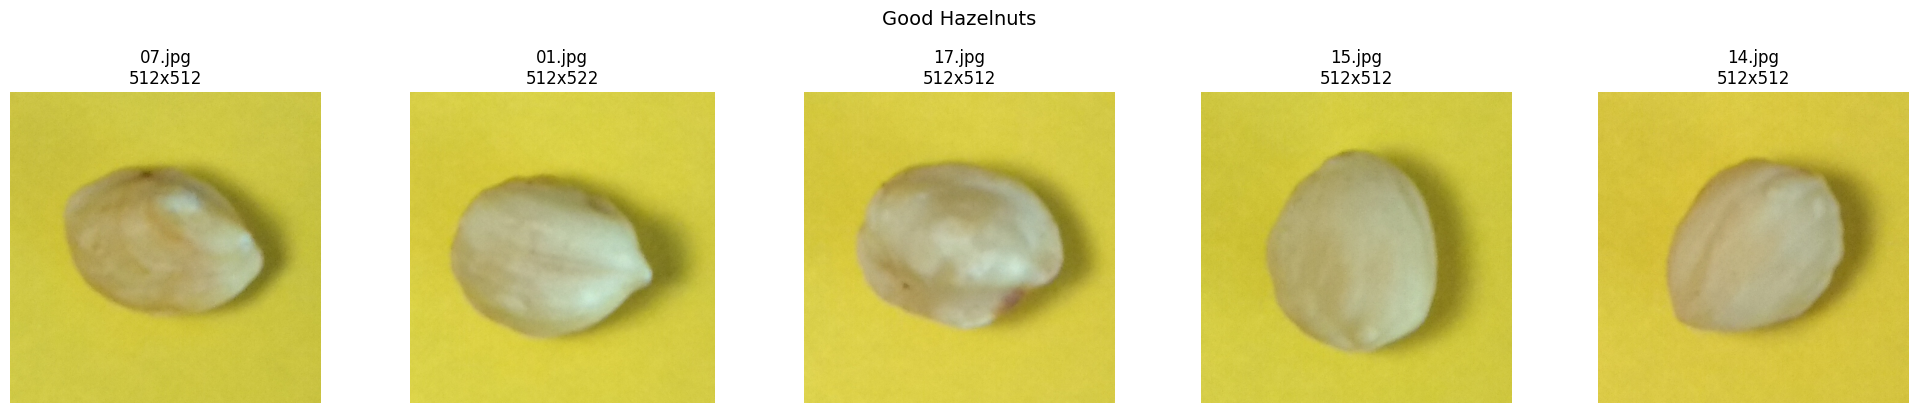

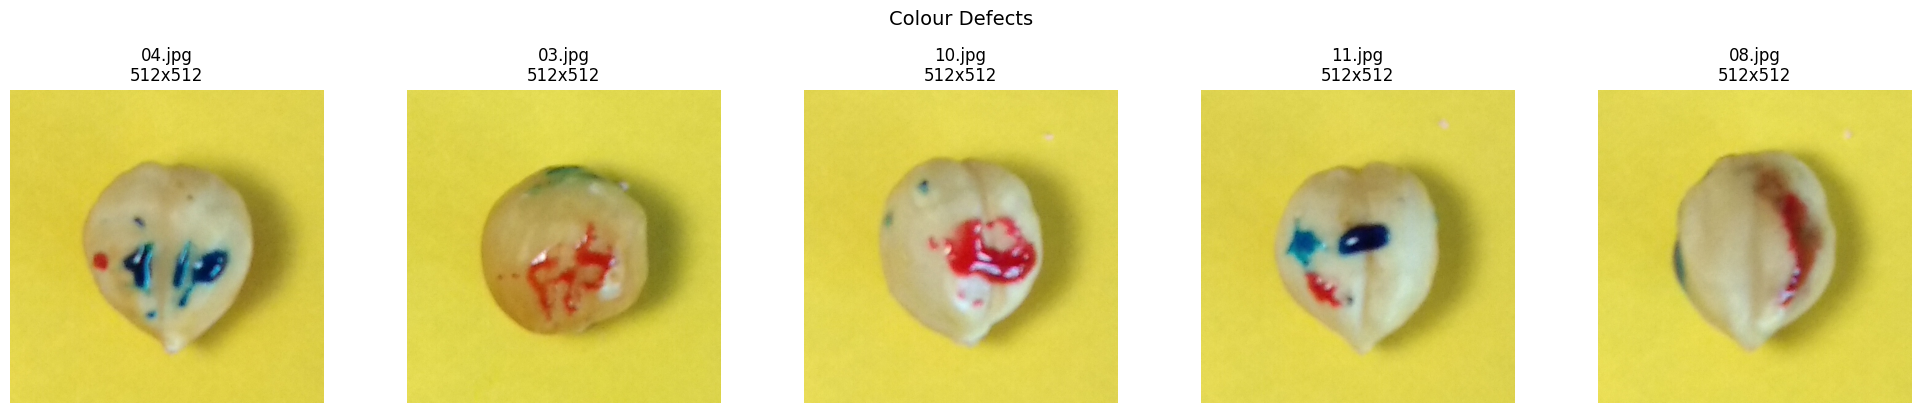

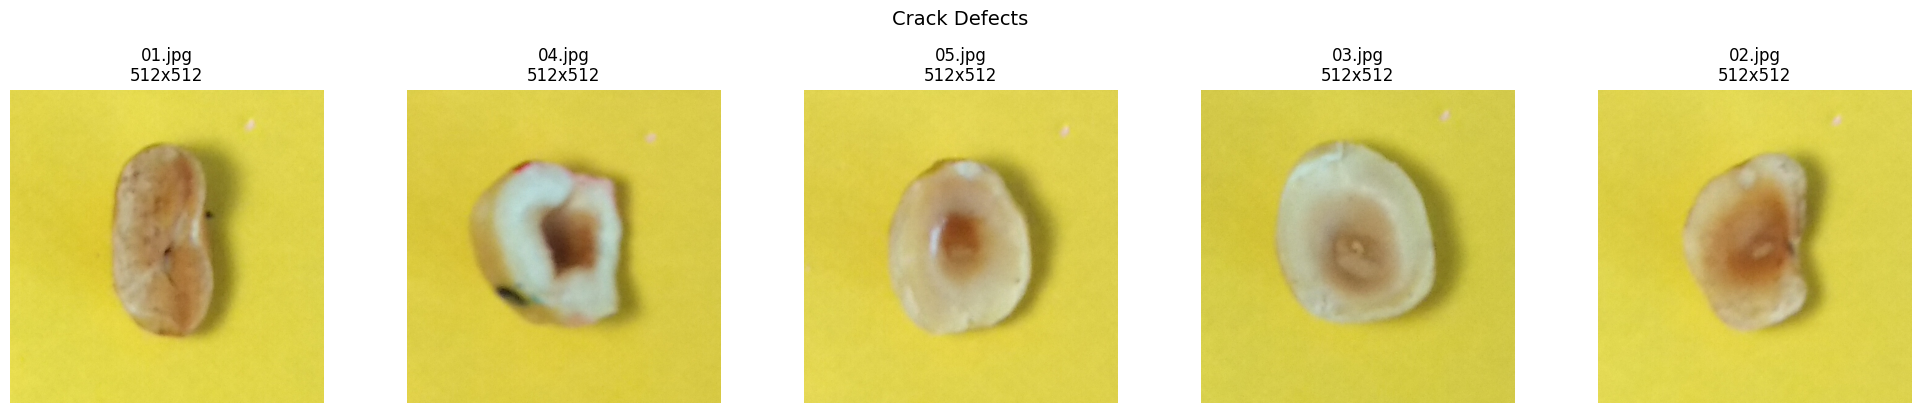

In [7]:
# Display sample images from each class
def display_samples(images, title, n=4):
    if not images:
        print(f"No images for {title}")
        return
    
    n = min(n, len(images))
    samples = random.sample(images, n)
    
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    
    for ax, p in zip(axes, samples):
        img = Image.open(p)
        ax.imshow(img)
        ax.set_title(f"{p.name}\n{img.size[0]}x{img.size[1]}")
        ax.axis("off")
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

display_samples(good_images, "Good Hazelnuts", n=5)
display_samples(colour_images, "Colour Defects", n=5)
display_samples(crack_images, "Crack Defects", n=5)

## 4. Mask Analysis

In [8]:
# Check mask coverage
mask_colour_dir = mask_dir / "colour"
mask_crack_dir = mask_dir / "crack"

mask_colour = list_images(mask_colour_dir)
mask_crack = list_images(mask_crack_dir)

print(f"Colour masks: {len(mask_colour)} (images: {len(colour_images)})")
print(f"Crack masks: {len(mask_crack)} (images: {len(crack_images)})")

# Check alignment
colour_stems = {p.stem for p in colour_images}
mask_colour_stems = {p.stem for p in mask_colour}

crack_stems = {p.stem for p in crack_images}
mask_crack_stems = {p.stem for p in mask_crack}

print(f"\nColour - Missing masks: {colour_stems - mask_colour_stems}")
print(f"Colour - Orphan masks: {mask_colour_stems - colour_stems}")
print(f"Crack - Missing masks: {crack_stems - mask_crack_stems}")
print(f"Crack - Orphan masks: {mask_crack_stems - crack_stems}")

Colour masks: 17 (images: 17)
Crack masks: 5 (images: 5)

Colour - Missing masks: set()
Colour - Orphan masks: set()
Crack - Missing masks: set()
Crack - Orphan masks: set()


In [9]:
# Mask coverage analysis
def analyze_masks(defect_class, image_dir, mask_subdir):
    images = list_images(image_dir)
    masks = list_images(mask_dir / mask_subdir)
    
    results = []
    for p in images:
        mask_path = mask_dir / mask_subdir / p.name
        if not mask_path.exists():
            # Try with different extension
            for ext in exts:
                alt_path = mask_dir / mask_subdir / (p.stem + ext)
                if alt_path.exists():
                    mask_path = alt_path
                    break
        
        if mask_path.exists():
            with Image.open(mask_path) as mask_img:
                mask_arr = np.asarray(mask_img.convert("L"))
                coverage = (mask_arr > 0).mean()
                results.append({
                    "class": defect_class,
                    "image": p.name,
                    "coverage": coverage,
                    "defect_pixels": (mask_arr > 0).sum(),
                    "total_pixels": mask_arr.size,
                })
    
    return results

mask_stats = []
mask_stats.extend(analyze_masks("colour", colour_dir, "colour"))
mask_stats.extend(analyze_masks("crack", crack_dir, "crack"))

mask_df = pd.DataFrame(mask_stats)
mask_df

class   image  coverage  defect_pixels  total_pixels
0   colour  00.jpg  0.019184           5029        262144
1   colour  01.jpg  0.026695           6998        262144
2   colour  02.jpg  0.033779           8855        262144
3   colour  03.jpg  0.047749          12517        262144
4   colour  04.jpg  0.033451           8769        262144
5   colour  05.jpg  0.024174           6337        262144
6   colour  06.jpg  0.051895          13604        262144
7   colour  07.jpg  0.044636          11701        262144
8   colour  08.jpg  0.036564           9585        262144
9   colour  09.jpg  0.036629           9602        262144
10  colour  10.jpg  0.046860          12284        262144
11  colour  11.jpg  0.043785          11478        262144
12  colour  12.jpg  0.065998          17301        262144
13  colour  13.jpg  0.040432          10599        262144
14  colour  14.jpg  0.018478           4844        262144
15  colour  15.jpg  0.037106           9727        262144
16  colour  16.jpg  0.018539           4860        262144
17   crack  01.jpg  0.167854          44002        262144
18   crack  02.jpg  0.181835          47667        262144
19   crack  03.jpg  0.241650          63347        262144
20   crack  04.jpg  0.176094          46162        262144
21   crack  05.jpg  0.207935          54509        262144

Mask Coverage Summary:
       coverage                        image
           mean    std     min     max count
class                                       
colour   0.0368  0.013  0.0185  0.0660    17
crack    0.1951  0.030  0.1679  0.2416     5


/tmp/ipykernel_10051/253836524.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mask_df, x="class", y="coverage", palette="Set2")


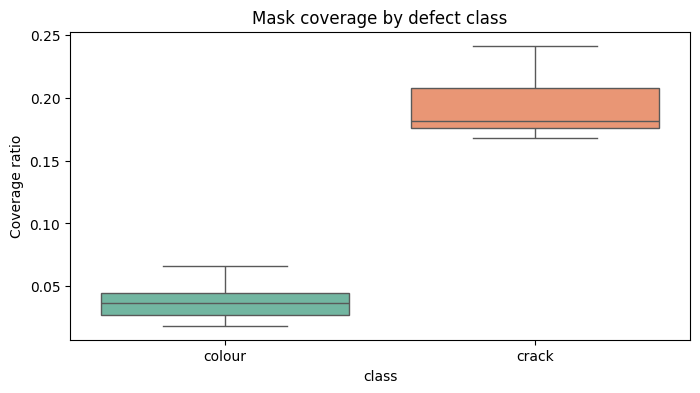

In [10]:
# Mask coverage summary
if not mask_df.empty:
    coverage_summary = mask_df.groupby("class").agg({
        "coverage": ["mean", "std", "min", "max"],
        "image": "count"
    }).round(4)
    print("Mask Coverage Summary:")
    print(coverage_summary)
    
    # Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=mask_df, x="class", y="coverage", palette="Set2")
    plt.title("Mask coverage by defect class")
    plt.ylabel("Coverage ratio")
    plt.show()

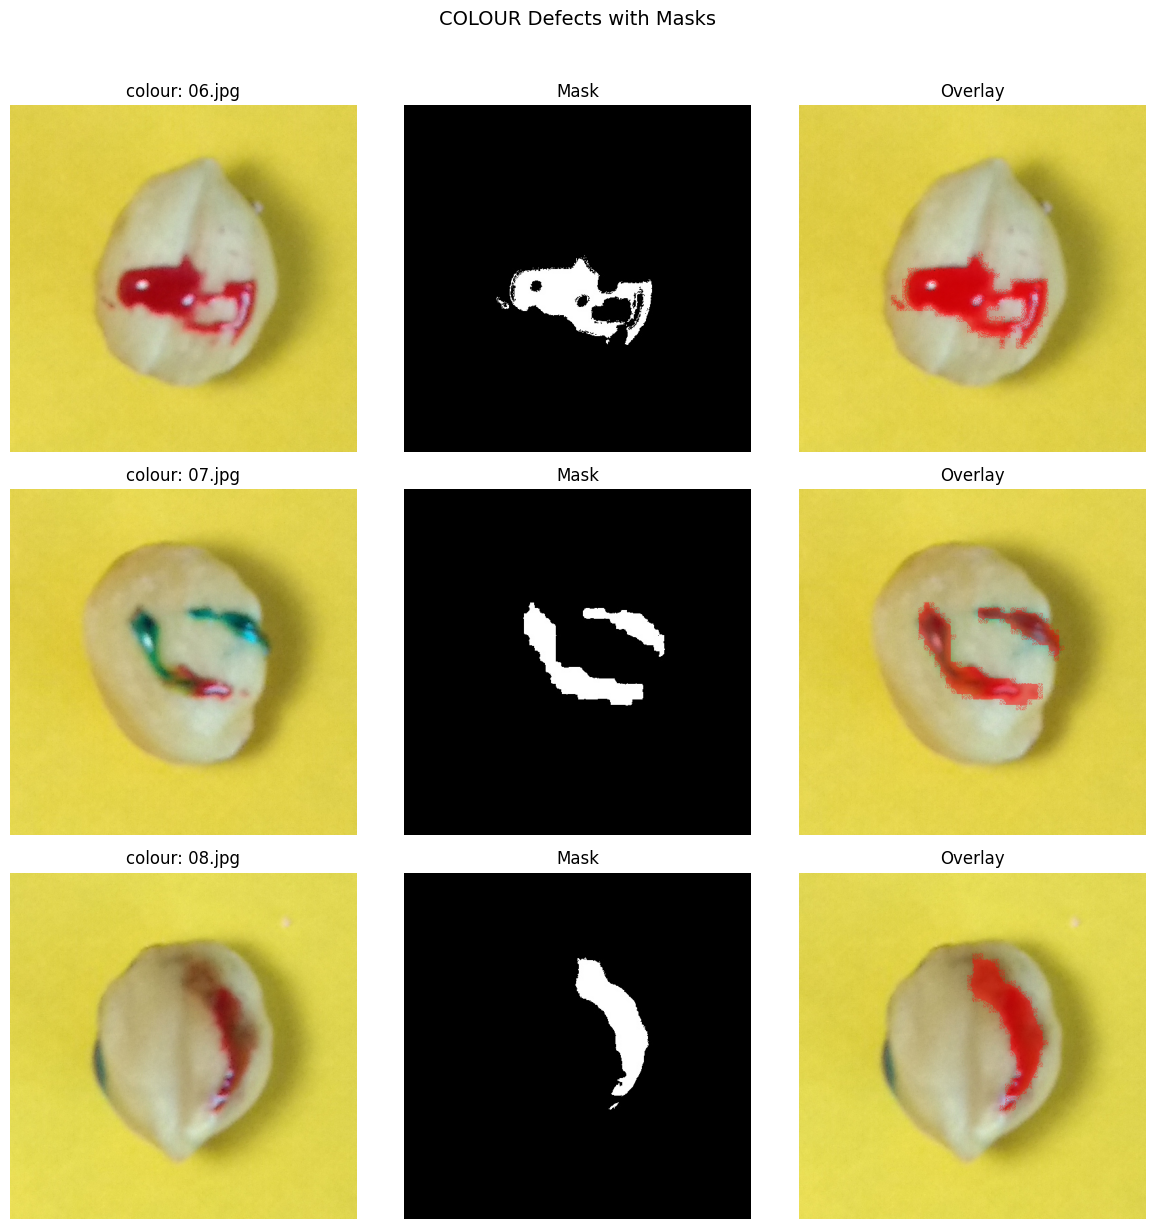

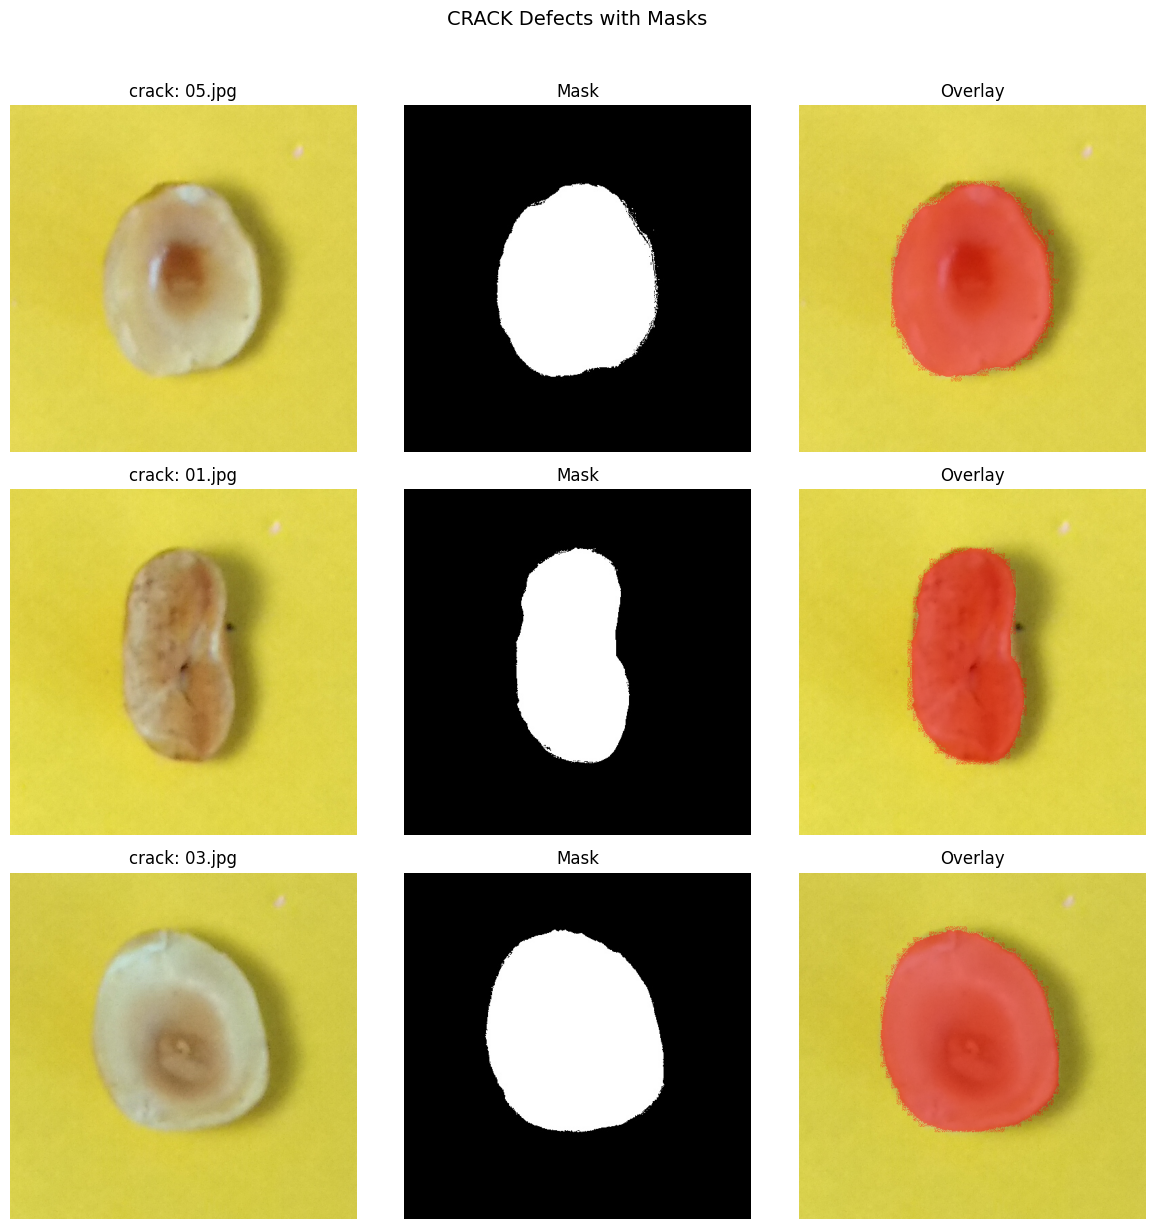

In [11]:
# Visual: Image + Mask + Overlay
def overlay_mask(img, mask, color=(255, 0, 0), alpha=0.5):
    img = img.convert("RGB")
    mask = mask.convert("L")
    arr = np.asarray(img).copy()
    m = np.asarray(mask) > 0
    arr[m] = (1 - alpha) * arr[m] + alpha * np.array(color)
    return arr.astype(np.uint8)

def show_defect_with_mask(defect_class, image_dir, mask_subdir):
    images = list_images(image_dir)
    if not images:
        return
    
    n_samples = min(3, len(images))
    samples = random.sample(images, n_samples)
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, p in enumerate(samples):
        mask_path = mask_dir / mask_subdir / p.name
        
        img = Image.open(p)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{defect_class}: {p.name}")
        axes[i, 0].axis("off")
        
        if mask_path.exists():
            mask = Image.open(mask_path)
            axes[i, 1].imshow(mask, cmap="gray")
            axes[i, 1].set_title("Mask")
            axes[i, 1].axis("off")
            
            overlay = overlay_mask(img, mask)
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title("Overlay")
            axes[i, 2].axis("off")
        else:
            axes[i, 1].text(0.5, 0.5, "No mask", ha="center", va="center")
            axes[i, 1].axis("off")
            axes[i, 2].axis("off")
    
    plt.suptitle(f"{defect_class.upper()} Defects with Masks", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

show_defect_with_mask("colour", colour_dir, "colour")
show_defect_with_mask("crack", crack_dir, "crack")

## 5. Intensity & Texture Analysis

In [12]:
# Per-image statistics
def compute_image_stats(p):
    with Image.open(p) as img:
        # Grayscale stats
        gray = img.convert("L")
        arr = np.asarray(gray, dtype=np.float32) / 255.0
        
        mean = float(arr.mean())
        std = float(arr.std())
        
        # Gradient (edge/texture indicator)
        gy, gx = np.gradient(arr)
        grad = float(np.sqrt(gx**2 + gy**2).mean())
        
        # RGB stats if color
        if img.mode == "RGB":
            rgb = np.asarray(img, dtype=np.float32) / 255.0
            r_mean, g_mean, b_mean = rgb.mean(axis=(0, 1))
        else:
            r_mean = g_mean = b_mean = mean
        
        return mean, std, grad, r_mean, g_mean, b_mean

stat_rows = []
for cls, p in tqdm(all_images, desc="Computing stats"):
    mean, std, grad, r, g, b = compute_image_stats(p)
    stat_rows.append({
        "class": cls,
        "path": str(p),
        "gray_mean": mean,
        "gray_std": std,
        "gradient": grad,
        "r_mean": r,
        "g_mean": g,
        "b_mean": b,
    })

stats_df = pd.DataFrame(stat_rows)
stats_df.head()

Computing stats: 100%|██████████| 56/56 [00:00<00:00, 64.55it/s]


class                         path  gray_mean  gray_std  gradient    r_mean  \
0  good  data/hazelnut_2/good/00.jpg   0.705796  0.069290  0.007261  0.795745   
1  good  data/hazelnut_2/good/01.jpg   0.722515  0.073956  0.007370  0.790479   
2  good  data/hazelnut_2/good/02.jpg   0.728746  0.089626  0.007223  0.810815   
3  good  data/hazelnut_2/good/03.jpg   0.726799  0.075929  0.007286  0.805677   
4  good  data/hazelnut_2/good/04.jpg   0.696680  0.075055  0.007728  0.784777   

     g_mean    b_mean  
0  0.738171  0.301465  
1  0.764584  0.322187  
2  0.768018  0.306566  
3  0.761942  0.336660  
4  0.731844  0.280782

In [13]:
# Summary statistics
stats_summary = stats_df.groupby("class").agg({
    "gray_mean": ["mean", "std"],
    "gray_std": ["mean", "std"],
    "gradient": ["mean", "std"],
    "r_mean": ["mean", "std"],
    "g_mean": ["mean", "std"],
    "b_mean": ["mean", "std"],
}).round(4)

print("Intensity/Texture Summary by Class:")
stats_summary

Intensity/Texture Summary by Class:


gray_mean         gray_std         gradient          r_mean          \
            mean     std     mean     std     mean     std    mean     std   
class                                                                        
colour    0.7281  0.0106   0.1050  0.0124   0.0084  0.0004  0.8148  0.0145   
crack     0.7326  0.0109   0.0862  0.0122   0.0078  0.0003  0.8217  0.0194   
good      0.6990  0.0133   0.0756  0.0080   0.0078  0.0003  0.7783  0.0129   

        g_mean          b_mean          
          mean     std    mean     std  
class                                   
colour  0.7619  0.0112  0.3230  0.0217  
crack   0.7677  0.0099  0.3143  0.0185  
good    0.7364  0.0148  0.2954  0.0204

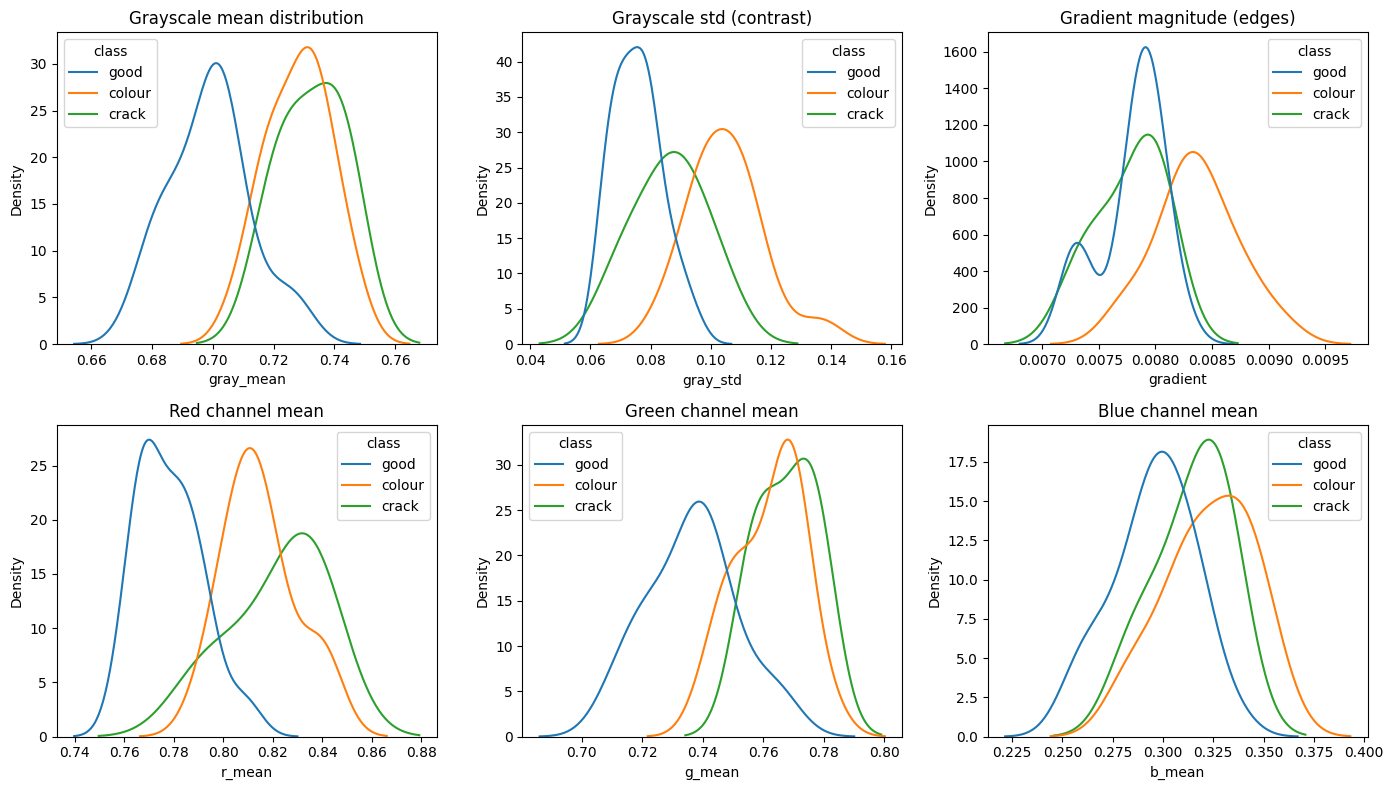

In [14]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Grayscale mean
sns.kdeplot(data=stats_df, x="gray_mean", hue="class", ax=axes[0, 0], common_norm=False)
axes[0, 0].set_title("Grayscale mean distribution")

# Grayscale std (contrast)
sns.kdeplot(data=stats_df, x="gray_std", hue="class", ax=axes[0, 1], common_norm=False)
axes[0, 1].set_title("Grayscale std (contrast)")

# Gradient (edges)
sns.kdeplot(data=stats_df, x="gradient", hue="class", ax=axes[0, 2], common_norm=False)
axes[0, 2].set_title("Gradient magnitude (edges)")

# RGB channels
sns.kdeplot(data=stats_df, x="r_mean", hue="class", ax=axes[1, 0], common_norm=False)
axes[1, 0].set_title("Red channel mean")

sns.kdeplot(data=stats_df, x="g_mean", hue="class", ax=axes[1, 1], common_norm=False)
axes[1, 1].set_title("Green channel mean")

sns.kdeplot(data=stats_df, x="b_mean", hue="class", ax=axes[1, 2], common_norm=False)
axes[1, 2].set_title("Blue channel mean")

plt.tight_layout()
plt.show()

## 6. Background Analysis

Understanding backgrounds is crucial for real-world deployment. MVTec has perfect black backgrounds - let's check this dataset.

In [15]:
# Sample corner pixels to detect background type
def analyze_background(p, margin=20):
    with Image.open(p) as img:
        arr = np.asarray(img.convert("RGB"), dtype=np.float32)
        h, w = arr.shape[:2]
        
        # Sample corners
        corners = [
            arr[:margin, :margin],           # top-left
            arr[:margin, -margin:],          # top-right
            arr[-margin:, :margin],          # bottom-left
            arr[-margin:, -margin:],         # bottom-right
        ]
        
        corner_vals = np.concatenate([c.reshape(-1, 3) for c in corners], axis=0)
        
        mean_val = corner_vals.mean()
        std_val = corner_vals.std()
        
        # Classify background
        if mean_val < 30:
            bg_type = "black"
        elif mean_val > 225:
            bg_type = "white"
        else:
            bg_type = "colored/textured"
        
        return mean_val, std_val, bg_type

bg_results = []
for cls, p in tqdm(all_images, desc="Analyzing backgrounds"):
    mean, std, bg_type = analyze_background(p)
    bg_results.append({
        "class": cls,
        "path": str(p),
        "bg_mean": mean,
        "bg_std": std,
        "bg_type": bg_type,
    })

bg_df = pd.DataFrame(bg_results)

print("Background type distribution:")
print(bg_df["bg_type"].value_counts())
print("\nBy class:")
print(bg_df.groupby(["class", "bg_type"]).size().unstack(fill_value=0))

Analyzing backgrounds: 100%|██████████| 56/56 [00:00<00:00, 117.51it/s]

Background type distribution:
bg_type
colored/textured    56
Name: count, dtype: int64

By class:
bg_type  colored/textured
class                    
colour                 17
crack                   5
good                   34


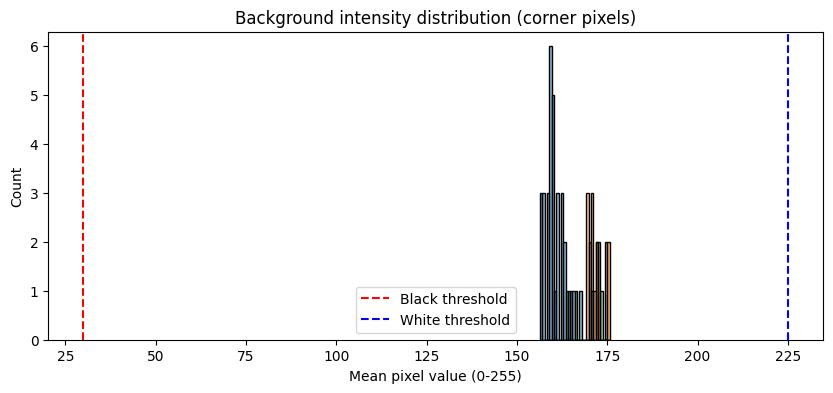

In [16]:
# Background intensity distribution
plt.figure(figsize=(10, 4))
sns.histplot(data=bg_df, x="bg_mean", hue="class", bins=30)
plt.title("Background intensity distribution (corner pixels)")
plt.xlabel("Mean pixel value (0-255)")
plt.axvline(x=30, color="red", linestyle="--", label="Black threshold")
plt.axvline(x=225, color="blue", linestyle="--", label="White threshold")
plt.legend()
plt.show()

## 7. SSIM Analysis (Similarity)

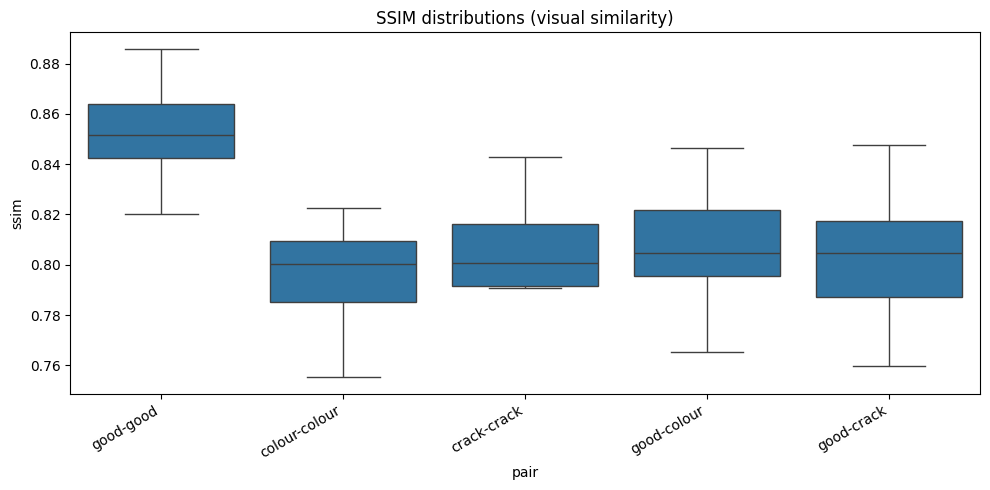


SSIM Summary:
               count   mean    std    min    25%    50%    75%    max
pair                                                                 
colour-colour   50.0  0.796  0.017  0.755  0.785  0.800  0.809  0.822
crack-crack     10.0  0.807  0.018  0.791  0.792  0.801  0.816  0.843
good-colour     50.0  0.808  0.020  0.765  0.796  0.805  0.822  0.846
good-crack      50.0  0.803  0.022  0.760  0.787  0.805  0.817  0.848
good-good       50.0  0.852  0.017  0.820  0.842  0.852  0.864  0.886


In [17]:
from skimage.metrics import structural_similarity as ssim

def load_gray(p, size=(256, 256)):
    img = Image.open(p).convert("L")
    if size:
        img = img.resize(size, Image.BILINEAR)
    return np.asarray(img)

def ssim_pairs(files_a, files_b=None, n_pairs=50, size=(256, 256)):
    scores = []
    if files_b is None:
        if len(files_a) < 2:
            return scores
        for _ in range(min(n_pairs, len(files_a) * (len(files_a) - 1) // 2)):
            p1, p2 = random.sample(files_a, 2)
            i1 = load_gray(p1, size)
            i2 = load_gray(p2, size)
            scores.append(ssim(i1, i2))
    else:
        if not files_a or not files_b:
            return scores
        for _ in range(min(n_pairs, len(files_a) * len(files_b))):
            p1 = random.choice(files_a)
            p2 = random.choice(files_b)
            i1 = load_gray(p1, size)
            i2 = load_gray(p2, size)
            scores.append(ssim(i1, i2))
    return scores

ssim_rows = []

# Within-class similarity
for v in ssim_pairs(good_images, None, n_pairs=50):
    ssim_rows.append({"pair": "good-good", "ssim": v})

for v in ssim_pairs(colour_images, None, n_pairs=50):
    ssim_rows.append({"pair": "colour-colour", "ssim": v})

for v in ssim_pairs(crack_images, None, n_pairs=10):  # Only 5 images
    ssim_rows.append({"pair": "crack-crack", "ssim": v})

# Cross-class similarity
for v in ssim_pairs(good_images, colour_images, n_pairs=50):
    ssim_rows.append({"pair": "good-colour", "ssim": v})

for v in ssim_pairs(good_images, crack_images, n_pairs=50):
    ssim_rows.append({"pair": "good-crack", "ssim": v})

ssim_df = pd.DataFrame(ssim_rows)

plt.figure(figsize=(10, 5))
sns.boxplot(data=ssim_df, x="pair", y="ssim")
plt.title("SSIM distributions (visual similarity)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

print("\nSSIM Summary:")
print(ssim_df.groupby("pair")["ssim"].describe().round(3))

## 8. Feature-Space Separability

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, silhouette_score

def featurize(p, size=(64, 64)):
    img = Image.open(p).convert("L")
    img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr.flatten()

# Build feature matrix
features = []
labels = []
binary_labels = []

for cls, p in tqdm(all_images, desc="Featurizing"):
    features.append(featurize(p))
    labels.append(cls)
    binary_labels.append(0 if cls == "good" else 1)

X = np.vstack(features)
y = np.array(labels)
y_bin = np.array(binary_labels)

print(f"Feature matrix shape: {X.shape}")

Featurizing: 100%|██████████| 56/56 [00:00<00:00, 133.54it/s]

Feature matrix shape: (56, 4096)


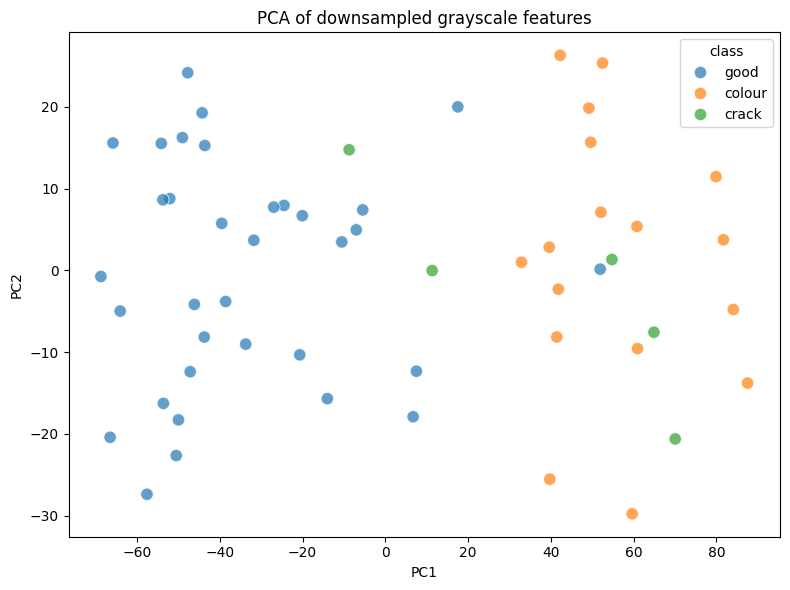

Silhouette score (PCA 2D): 0.3228


In [19]:
# PCA visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=SEED)
X_2d = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({"PC1": X_2d[:, 0], "PC2": X_2d[:, 1], "class": y})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="class", alpha=0.7, s=80)
plt.title("PCA of downsampled grayscale features")
plt.tight_layout()
plt.show()

# Silhouette score
sil_score = silhouette_score(X_2d, y)
print(f"Silhouette score (PCA 2D): {sil_score:.4f}")

In [20]:
# Binary classification: Good vs Defect
print("=== Binary Classification (Good vs Defect) ===")

# Cross-validation
clf_bin = LogisticRegression(max_iter=1000, random_state=SEED)
cv_scores = cross_val_score(clf_bin, X_scaled, y_bin, cv=5, scoring="f1")
print(f"5-fold CV F1 scores: {cv_scores.round(3)}")
print(f"Mean F1: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Train/test split
if len(np.unique(y_bin)) > 1 and min(np.bincount(y_bin)) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_bin, test_size=0.3, random_state=SEED, stratify=y_bin
    )
    clf_bin.fit(X_train, y_train)
    pred = clf_bin.predict(X_test)
    
    print(f"\nTest Accuracy: {accuracy_score(y_test, pred):.3f}")
    print(f"Test F1: {f1_score(y_test, pred):.3f}")

=== Binary Classification (Good vs Defect) ===
5-fold CV F1 scores: [0.8   1.    1.    1.    0.889]
Mean F1: 0.938 (+/- 0.162)

Test Accuracy: 0.941
Test F1: 0.923



=== Multiclass Classification ===
5-fold CV Accuracy: [0.917 1.    1.    1.    1.   ]
Mean Accuracy: 0.983 (+/- 0.067)

Classification Report:
              precision    recall  f1-score   support

      colour       0.83      1.00      0.91         5
       crack       1.00      0.50      0.67         2
        good       1.00      1.00      1.00        10

    accuracy                           0.94        17
   macro avg       0.94      0.83      0.86        17
weighted avg       0.95      0.94      0.93        17



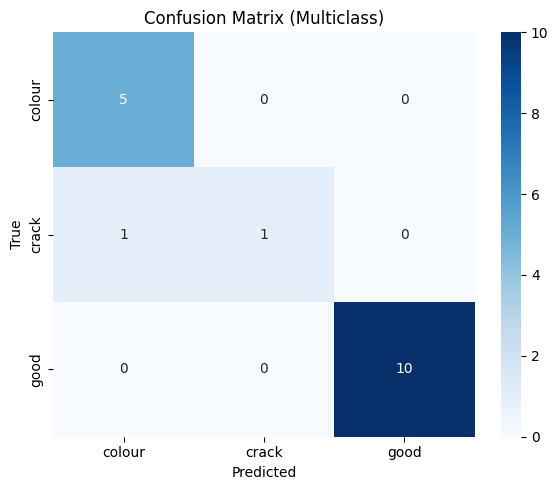

In [21]:
# Multiclass classification
print("\n=== Multiclass Classification ===")

clf_multi = LogisticRegression(max_iter=1000, random_state=SEED)
cv_scores_multi = cross_val_score(clf_multi, X_scaled, y, cv=5, scoring="accuracy")
print(f"5-fold CV Accuracy: {cv_scores_multi.round(3)}")
print(f"Mean Accuracy: {cv_scores_multi.mean():.3f} (+/- {cv_scores_multi.std()*2:.3f})")

# Confusion matrix
if min([len(good_images), len(colour_images), len(crack_images)]) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=SEED, stratify=y
    )
    clf_multi.fit(X_train, y_train)
    pred_multi = clf_multi.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, pred_multi))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, pred_multi)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
    plt.title("Confusion Matrix (Multiclass)")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

## 9. Comparison with MVTec Dataset

In [22]:
# Summary comparison table
comparison = pd.DataFrame([
    {
        "Metric": "Total images",
        "MVTec (hazelnut_1)": "~501",
        "hazelnut_2": str(len(all_images)),
    },
    {
        "Metric": "Good images",
        "MVTec (hazelnut_1)": "391 train + 40 test",
        "hazelnut_2": str(len(good_images)),
    },
    {
        "Metric": "Defect images",
        "MVTec (hazelnut_1)": "70 (crack, cut, hole, print)",
        "hazelnut_2": f"{len(colour_images) + len(crack_images)} (colour, crack)",
    },
    {
        "Metric": "Defect ratio",
        "MVTec (hazelnut_1)": "~14%",
        "hazelnut_2": f"{(len(colour_images) + len(crack_images)) / len(all_images):.0%}",
    },
    {
        "Metric": "Image resolution",
        "MVTec (hazelnut_1)": "1024x1024",
        "hazelnut_2": f"{img_df['width'].mode().iloc[0] if len(img_df) > 0 else 'N/A'}x{img_df['height'].mode().iloc[0] if len(img_df) > 0 else 'N/A'}",
    },
    {
        "Metric": "Background",
        "MVTec (hazelnut_1)": "Perfect black",
        "hazelnut_2": bg_df["bg_type"].mode().iloc[0] if len(bg_df) > 0 else "Unknown",
    },
    {
        "Metric": "Train/Test split",
        "MVTec (hazelnut_1)": "Yes",
        "hazelnut_2": "No",
    },
    {
        "Metric": "Segmentation masks",
        "MVTec (hazelnut_1)": "Yes (all defects)",
        "hazelnut_2": "Yes (colour, crack)",
    },
])

print("=== Dataset Comparison ===")
comparison

=== Dataset Comparison ===


Metric            MVTec (hazelnut_1)           hazelnut_2
0        Total images                          ~501                   56
1         Good images           391 train + 40 test                   34
2       Defect images  70 (crack, cut, hole, print)   22 (colour, crack)
3        Defect ratio                          ~14%                  39%
4    Image resolution                     1024x1024              512x512
5          Background                 Perfect black     colored/textured
6    Train/Test split                           Yes                   No
7  Segmentation masks             Yes (all defects)  Yes (colour, crack)

## 10. Recommendations for More Robust Data

Based on this analysis, here are recommendations for improving your dataset:

In [23]:
recommendations = """
### Key Observations

1. **Dataset Size**: hazelnut_2 is very small (56 images vs MVTec's 500+)
   - High risk of overfitting
   - Limited generalization capability

2. **Class Imbalance**: 
   - Crack class has only 5 images (severely underrepresented)
   - Consider collecting more crack samples or using data augmentation

3. **Background Variation**: Analyze if backgrounds differ from MVTec
   - If backgrounds are more varied, this is actually GOOD for generalization
   - Factory deployment will have varying conditions

### Recommendations for More Robust Data

1. **Data Collection**:
   - Collect more images, especially for underrepresented classes
   - Target at least 100+ images per class for meaningful training
   - Vary lighting conditions, camera angles, and backgrounds

2. **Data Augmentation**:
   - Rotation, flipping, scaling
   - Color jittering (especially useful for colour defects)
   - Elastic deformation
   - Cutout/random erasing
   - Consider using libraries like Albumentations or imgaug

3. **Additional Public Datasets**:
   - DAGM 2007 texture defect dataset
   - Kolektor Surface-Defect Dataset (KolektorSDD)
   - NEU Surface Defect Database (steel surfaces)
   - Magnetic tile defect dataset
   - VisA (Visual Anomaly) dataset

4. **Synthetic Data Generation**:
   - Use GANs (e.g., DefectGAN) to generate synthetic defects
   - Copy-paste defect regions onto good images
   - Consider diffusion models for high-quality augmentation

5. **Domain Adaptation**:
   - Combine MVTec and hazelnut_2 with domain adaptation techniques
   - Use transfer learning from pre-trained anomaly detection models

6. **Semi-supervised Learning**:
   - Collect unlabeled hazelnut images (easier than labeled)
   - Use self-supervised pre-training
   - Consider models like PatchCore, PADIM, or CFlow
"""

from IPython.display import Markdown
display(Markdown(recommendations))


### Key Observations

1. **Dataset Size**: hazelnut_2 is very small (56 images vs MVTec's 500+)
   - High risk of overfitting
   - Limited generalization capability

2. **Class Imbalance**: 
   - Crack class has only 5 images (severely underrepresented)
   - Consider collecting more crack samples or using data augmentation

3. **Background Variation**: Analyze if backgrounds differ from MVTec
   - If backgrounds are more varied, this is actually GOOD for generalization
   - Factory deployment will have varying conditions

### Recommendations for More Robust Data

1. **Data Collection**:
   - Collect more images, especially for underrepresented classes
   - Target at least 100+ images per class for meaningful training
   - Vary lighting conditions, camera angles, and backgrounds

2. **Data Augmentation**:
   - Rotation, flipping, scaling
   - Color jittering (especially useful for colour defects)
   - Elastic deformation
   - Cutout/random erasing
   - Consider using libraries like Albumentations or imgaug

3. **Additional Public Datasets**:
   - DAGM 2007 texture defect dataset
   - Kolektor Surface-Defect Dataset (KolektorSDD)
   - NEU Surface Defect Database (steel surfaces)
   - Magnetic tile defect dataset
   - VisA (Visual Anomaly) dataset

4. **Synthetic Data Generation**:
   - Use GANs (e.g., DefectGAN) to generate synthetic defects
   - Copy-paste defect regions onto good images
   - Consider diffusion models for high-quality augmentation

5. **Domain Adaptation**:
   - Combine MVTec and hazelnut_2 with domain adaptation techniques
   - Use transfer learning from pre-trained anomaly detection models

6. **Semi-supervised Learning**:
   - Collect unlabeled hazelnut images (easier than labeled)
   - Use self-supervised pre-training
   - Consider models like PatchCore, PADIM, or CFlow


## Summary

Run all cells above to complete the EDA. Key findings will be populated in the TLDR section at the top after execution.